In [64]:
import numpy as np

import os ,sys

import random

import matplotlib.pyplot as plt

import pandas as pd

import copy


from matplotlib.ticker import MultipleLocator, FormatStrFormatter


import scipy.stats as stats

In [81]:
Estimate_Path='./Data/Estimation/'

Collect_Path='./Data/Collection/'

Valicate_Path='./Data/Prediction/'

Labels=['A','B','C']

The_number_of_Shifts=np.load(os.path.join(Estimate_Path,'The_number_of_Shifts.npy')).item()

First_shift_start_time=np.load(os.path.join(Estimate_Path,'First_shift_start_time.npy')).item()

Duration_discrete_Param=np.load(os.path.join(Estimate_Path,'Duration_discrete_Param.npy')).item()

Gap_discrete_Param=np.load(os.path.join(Estimate_Path,'Gap_discrete_Param.npy')).item()



Clustered_DF=pd.read_csv(os.path.join(Collect_Path,'Clustered_DF.csv'))

Clustered_DF=Clustered_DF.drop(columns=['Unnamed: 0'])

Count_Stat=Clustered_DF.loc[Clustered_DF['date']==20161113].groupby('label').count()

Count_Stat['label']=Count_Stat.index

Count_Stat=Count_Stat[['label','Driver_id']]

Count_Stat=Count_Stat.rename(columns={'Driver_id':'Driver_Num'})

Count_Stat=Count_Stat.reset_index(drop=True)

Driver_count={}


for idx,row in Count_Stat.iterrows():
    
    label=row['label']
    
    num=row['Driver_Num']
    
    Driver_count[label]=num

Driver_count


{'A': 16965, 'B': 15076, 'C': 6040}

## 01 Sample the number of shifts

In [82]:
'''Shifts quantity'''

def Random_pick(distribution,driver_count,cluster):
    
    num=driver_count[cluster]
    
    dic=distribution[cluster]
    
    return np.array([np.random.choice(list(dic.keys()),p=list(dic.values())) for i in range(num)])

shiftNum_A=Random_pick(The_number_of_Shifts,Driver_count,'A')

shiftNum_B=Random_pick(The_number_of_Shifts,Driver_count,'B')

shiftNum_C=Random_pick(The_number_of_Shifts,Driver_count,'C')

Shifts_Num={'A':{i:shiftNum_A[i] for i in range(Driver_count['A'])},\
            'B':{j:shiftNum_B[j] for j in range(Driver_count['B'])},\
            'C':{k:shiftNum_C[k] for k in range(Driver_count['C'])}}

## 02 First shift start time

In [83]:
'''First Shift Start Hour'''

class Sampling(object):
    
    def __init__(self,Param):
        
        self.modal=int((len(Param)-2)/3)
        
        self.mu=list()
        
        self.sigma=list()
        
        self.A=list()
        
        for i in range(self.modal):
            
            self.mu.append(Param['mu'+str(i+1)])
            
            self.sigma.append(Param['sigma'+str(i+1)])
            
            self.A.append(Param['A'+str(i+1)])
            
        self.min_=round(Param['min'],2)
        
        self.max_=round(Param['max'],2)+0.01

    def gauss(self,x,mu,sigma,A):
        
        return A*np.exp(-(x-mu)**2/2/sigma**2)*(1/np.sqrt(2*np.pi)/sigma)
    
    def Multi_Modal(self,x):
        
        num=0
        
        for i in range(self.modal):
            
            num+=self.gauss(x,self.mu[i],self.sigma[i],self.A[i])
            
        return num

    
    def discrete_sampler(self,quantity):
        
        Samples_dic={}
        
        for x in np.arange(self.min_,self.max_,0.01):

            r=self.Multi_Modal(x)

            Samples_dic[x]=r
            
        Norm=sum(Samples_dic.values())

        Samples_dic={k:v/Norm for k,v in Samples_dic.items()}
        
        arr=[np.random.choice(list(Samples_dic.keys()),p=list(Samples_dic.values())) for i in range(quantity)]
        
        return arr

Samp=Sampling(First_shift_start_time['A'])

First_Shift_Start_Hour_A=Samp.discrete_sampler(Driver_count['A'])

Samp=Sampling(First_shift_start_time['B'])

First_Shift_Start_Hour_B=Samp.discrete_sampler(Driver_count['B'])

Samp=Sampling(First_shift_start_time['C'])

First_Shift_Start_Hour_C=Samp.discrete_sampler(Driver_count['C'])

Shifts={'A':{i:{'Start':[First_Shift_Start_Hour_A[i]],'End':[]} for i in range(Driver_count['A'])},\
        'B':{j:{'Start':[First_Shift_Start_Hour_B[j]],'End':[]} for j in range(Driver_count['B'])},\
        'C':{k:{'Start':[First_Shift_Start_Hour_C[k]],'End':[]} for k in range(Driver_count['C'])}}

## 03  Shift Duration and  Gap between two shifts

In [84]:
'''Truncted Gaussian Sampler'''

def Truncted_sampler(mu, sigma, lower, upper):

    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    
    return X.rvs(1)[0]

for cluster,shifts in Shifts.items():
    
    for driver_id in shifts.keys():
        
        if driver_id%5000==0:
        
            print(cluster,driver_id)
        
        shift_num=Shifts_Num[cluster][driver_id]
        
        while True:
            
            Start_time=Shifts[cluster][driver_id]['Start'][-1]
                 
            Start_hour=int(Start_time)
            
            duration=Truncted_sampler(Duration_discrete_Param[cluster][Start_hour]['mean'],\
                                      Duration_discrete_Param[cluster][Start_hour]['std'],\
                                      Duration_discrete_Param[cluster][Start_hour]['min'],\
                                      Duration_discrete_Param[cluster][Start_hour]['max'])
        
    
                
            Shifts[cluster][driver_id]['End'].append(Start_time+duration)
                
            if len(Shifts[cluster][driver_id]['End'])==shift_num:
                    
                break
                    
            End_Time=Shifts[cluster][driver_id]['End'][-1]

            End_hour=int(End_Time)

            if End_hour<22:

                gap=Truncted_sampler(Gap_discrete_Param[cluster][End_hour]['mean'],\
                                     Gap_discrete_Param[cluster][End_hour]['std'],\
                                     Gap_discrete_Param[cluster][End_hour]['min'],\
                                     Gap_discrete_Param[cluster][End_hour]['max'])
            else:

                gap=2


            if End_Time+gap>24.0:
                    
                break
                    
            else:

                Shifts[cluster][driver_id]['Start'].append(End_Time+gap)

A 0
A 5000
A 10000
A 15000
B 0
B 5000
B 10000
B 15000
C 0
C 5000


## 04 Statistics

In [85]:
def explode(df, col):
    df[col] = df[col].apply(lambda x: [x] if not isinstance(x, list) else x)
    return df.drop(col, axis=1).join(
        pd.DataFrame(list(df[col])).stack().reset_index(level=1, drop=True).rename(col)
    ) 


Pred_df=pd.DataFrame([],columns=['Start','End'])

for cluster in Labels:

    df=pd.DataFrame(Shifts[cluster].values())
    
    df=df[['Start','End']]
    
    Pred_df=pd.concat([Pred_df,df],ignore_index=True)
    
Pred_df=Pred_df[['Start','End']]

Pred_df['Transition']=Pred_df.apply(lambda x: [(x['Start'][i],x['End'][i]) for i in range(len(x['Start']))],axis=1)

Pred_df=Pred_df[['Transition']]

Pred_df=explode(Pred_df,'Transition')

Pred_df['Start']=Pred_df.apply(lambda x:round(x['Transition'][0],1),axis=1)

Pred_df['End']=Pred_df.apply(lambda x:round(x['Transition'][1],1),axis=1)

Pred_df['Active_range']=Pred_df.apply(lambda x:[round(y,1) for y in np.arange(x['Start'],x['End']+0.1,0.1)],axis=1)

Pred_df=Pred_df[['Active_range','Start']]

Pred_df=explode(Pred_df,'Active_range')

Pred_df=Pred_df.rename(columns={'Active_range':'step'})

Pred_df=Pred_df.groupby('step').count()

Pred_df['step']=Pred_df.index

Pred_df=Pred_df.rename(columns={'Start':'Count'})

Pred_df=Pred_df[['step','Count']]

Pred_df=Pred_df.reset_index(drop=True)

Pred_df=Pred_df.sort_values(by='step')

Pred_df=Pred_df.reset_index(drop=True)

Pred_df=Pred_df.loc[Pred_df['step']<=24.0]


Pred_array=np.array(Pred_df['Count'].to_list())

Step_array=np.array(Pred_df['step'].to_list())


Pred_df


,step,Count
0,0.1,332
1,0.2,790
2,0.3,1185
3,0.4,1539
4,0.5,1857
5,0.6,2126
6,0.7,2334
7,0.8,2503
8,0.9,2673
9,1.0,2753


## 05 Visualization

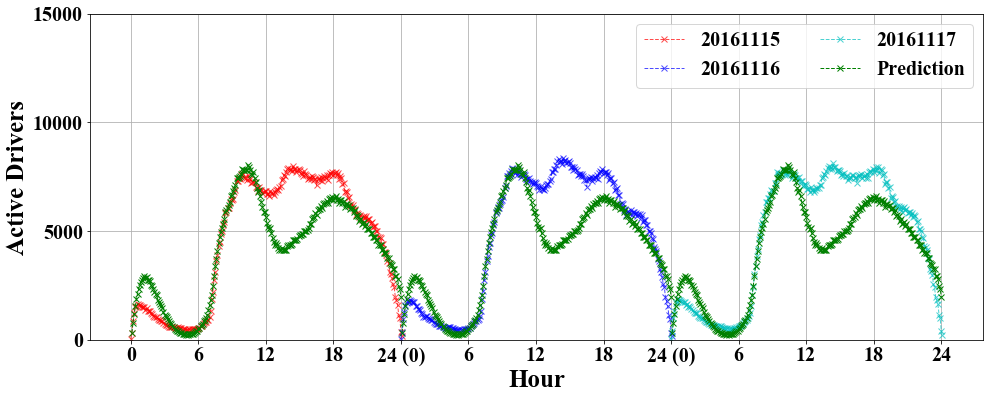

In [86]:
Validation=pd.read_csv(os.path.join(Valicate_Path,'Validation.csv'))

Validation=Validation.drop(columns=['Unnamed: 0'])

date_range=[dt for dt in range(20161115,20161118,1)]

Validation['date']=Validation['date'].astype('int32')

Validation['step']=Validation.apply(lambda x:x['step']+date_range.index(x['date'])*24,axis=1)

Validation




'''Plot Figure'''

figsize = 16,6

font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(figsize=figsize)

labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]

colors=['r','b','c']

for i in range(len(date_range)):
    
    steps=np.array(Validation.loc[Validation['date']==date_range[i],'step'])
    
    Counts=np.array(Validation.loc[Validation['date']==date_range[i],'Count'])

    ax1.plot(steps,Counts,colors[i]+'--',linewidth=1,marker='x', label=date_range[i],alpha=0.7)
    
    if i==2:
    
        ax1.plot(Step_array+i*24.0,Pred_array,'g--',linewidth=1,marker='x', label='Prediction',alpha=1)
    
    else:
        
        ax1.plot(Step_array+i*24.0,Pred_array,'g--',linewidth=1,marker='x',alpha=1)

ax1.set_ylabel('Active Drivers',font_label)

ax1.set_xlabel('Hour',font_label)

ax1.legend(loc = 'upper right',prop=font_legend,ncol=2)

ax1.set_ylim([0,15000])

xmajorLocator   = MultipleLocator(6)

ax1.xaxis.set_major_locator(xmajorLocator)

ymajorLocator   = MultipleLocator(5000)

ax1.yaxis.set_major_locator(ymajorLocator) 

ax1.set_xticklabels(['','0', '6','12', '18','24 (0)', '6','12', '18','24 (0)','6','12', '18','24'],font_legend)


plt.grid()

plt.show()
    
    